In [8]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [9]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [10]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [131]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [132]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [13]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [14]:
# Save references to each table
Measurements = Base.classes.measurement
Stations = Base.classes.station

In [133]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [16]:
# investigate table structure of 'measurement' table
first_row = session.query(Measurements).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1970120fa70>,
 'tobs': 65.0,
 'station': 'USC00519397',
 'date': '2010-01-01',
 'prcp': 0.08,
 'id': 1}

In [17]:
# investigate table structure of 'station' table
first_row = session.query(Stations).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1970120cef0>,
 'station': 'USC00519397',
 'latitude': 21.2716,
 'id': 1,
 'elevation': 3.0,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US'}

# Exploratory Precipitation Analysis

In [18]:
# Find the most recent date in the data set.
session.query(Measurements.date).order_by(Measurements.date.desc()).first()

('2017-08-23',)

In [96]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# the query later to filter data of most active station warrants the creation of a function
# to determine date of one year prior of any given end date --
# dates in sqlite are strings, need to convert to ISO date format to determine time (1 year) delta --
def one_year_prior_as_date (date_range_end):
    most_recent_date_str = date_range_end[0]
    # convert datet into datetime.date format
    most_recent_date_dt = dt.datetime.strptime(most_recent_date_str, '%Y-%m-%d').date()
    year_prior = most_recent_date_dt.year - 1
    # determine date one year prior, in datetime.date format (this format can be used in a sqlalchemy filter)
    year_prior_date = dt.datetime(year_prior, most_recent_date_dt.month, most_recent_date_dt.day).date()
    # return year_prior_date, most_recent_date_dt 
    return year_prior_date

In [97]:
# investigate number of rows in sqlite table: --
allrows = session.query(Measurements).count()
# need to determine if there are any Null (blanks) in prcp column in order to plot the data later --
allrows_filtered = session.query(Measurements).filter(Measurements.prcp != "").count()
print(f"There are a total of {allrows} rows in the measurements table; and \n  \
      {allrows_filtered} rows without blanks in the prcp column")


There are a total of 19550 rows in the measurements table; and 
        18103 rows without blanks in the prcp column


In [113]:
# Calculate the date one year from the last date in data set.
most_recent_date = session.query(Measurements.date).order_by(Measurements.date.desc()).first()
year_prior_date = one_year_prior_as_date(most_recent_date)  # using function
print(f"The date one year prior to the most recent date in the dateset is {year_prior_date}\n  \
      use this date as a string in the SurfsUp_app.py.")

The date one year prior to the most recent date in the dateset is 2016-08-23
        use this date as a string in the SurfsUp_app.py.


In [98]:
last_12_mo_data = session.query(Measurements).filter(Measurements.date >= year_prior_date)
# note: based on the provided solution, include 2016-08-23 in the analysis (thus '>=', not '>')
last_12_mo_data_clean = last_12_mo_data.filter(Measurements.prcp != "")
print(f"There are a total of {last_12_mo_data.count()} rows of data in last year of measurements; and \n  \
      of this subset, {last_12_mo_data_clean.count()} rows without blanks in the prcp column")

There are a total of 2230 rows of data in last year of measurements; and 
        of this subset, 2021 rows without blanks in the prcp column


In [127]:
# Perform a query to retrieve the data and precipitation scores
dates_list = []
precipitation_list = []
for row in last_12_mo_data_clean: 
    dates_list.append(row.date) 
    precipitation_list.append(row.prcp)     

In [26]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(
    {"date" : dates_list,
    "precp" : precipitation_list}
)
df
# note: 2021 rows for one year of data

,date,precp
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00
...,...,...
2016,2017-08-17,0.13
2017,2017-08-19,0.09
2018,2017-08-21,0.56
2019,2017-08-22,0.50


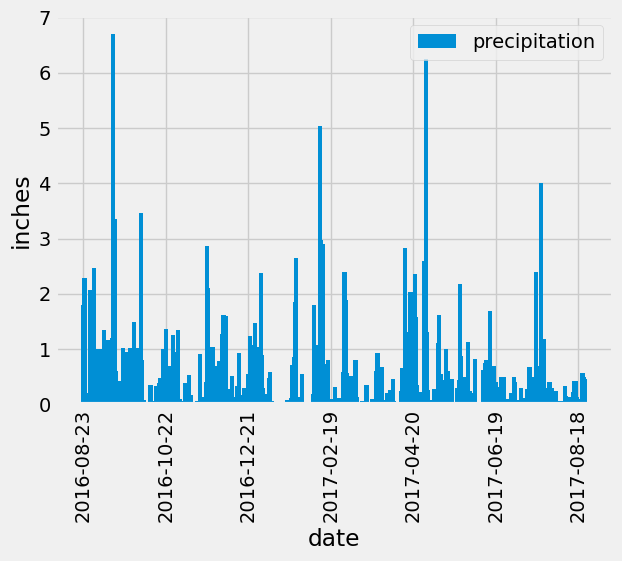

In [111]:
# Sort the dataframe by date
# for a bar plot of precipitation of the entire dateset, need to handle issue of multiple values for same day,
# because data comes from more than one station. To match provided solution, determine the maximum
# precipitation for each date --
sorted_df_by_date = df.sort_values('date')
precip_per_date = sorted_df_by_date.groupby(["date"])['precp'].max()

# Use Pandas Plotting with Matplotlib to plot the data
x_val = sorted_df_by_date['date']
y_val = sorted_df_by_date['precp']
# x-axis labels need to be in datetime format (not strings) --
most_recent_date_dt = dt.datetime.strptime(most_recent_date[0], '%Y-%m-%d').date()
x_labels = np.arange(year_prior_date, most_recent_date_dt, dt.timedelta(days = 60).days)
plt.xticks(rotation = 90)
plt.xticks(x_labels, x_labels)
plt.xlabel('date')
plt.ylabel('inches')
plt.bar(x_val, y_val, width=3, label = 'precipitation')
plt.legend()
plt.show()

In [114]:
# Use Pandas to calculate the summary statistics for the precipitation data
sorted_df_by_date['date'].count()
summstat = pd.DataFrame(sorted_df_by_date['precp'].describe())
summstat

,precp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [115]:
# Design a query to calculate the total number of stations in the dataset
session.query(Measurements.station).distinct().count()

9

In [117]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
sel = [Measurements.station, 
       func.count(Measurements.station)]
   
station_activity = session.query(*sel).\
    group_by(Measurements.station).\
    order_by(func.count(Measurements.station).desc()).all()
station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [118]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [ 
       func.min(Measurements.tobs), 
       func.max(Measurements.tobs), 
       func.avg(Measurements.tobs)
       ]
most_active_station = session.query(*sel).\
    filter_by(station = 'USC00519281').\
    all()
most_active_station

[(54.0, 85.0, 71.66378066378067)]

In [126]:
# prepare for analyzing most active station data, and related query of last 12 months of data -- 
latest_date_USC00519281 = session.query(Measurements.date).filter_by(station = 'USC00519281'). \
    order_by(Measurements.date.desc()).first()
year_prior_date_USC00519281 = one_year_prior_as_date(latest_date_USC00519281)
print(f"Note that the most recent date in the dateset filtered by station USC00519281 {latest_date_USC00519281} \n \
      is slightly different than the most recent date in the entire dataset {most_recent_date}.")
print(f"The date one year prior to the most recent date in the dateset filtered by station USC00519281 \n \
      is {year_prior_date_USC00519281}; use this date as a string in the SurfsUp_app.py.")

Note that the most recent date in the dateset filtered by station USC00519281 ('2017-08-18',) 
       is slightly different than the most recent date in the entire dataset ('2017-08-23',).
The date one year prior to the most recent date in the dateset filtered by station USC00519281 
       is 2016-08-18; use this date as a string in the SurfsUp_app.py.


In [123]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
USC00519281_only = session.query(Measurements).filter_by(station = 'USC00519281')
USC00519281_only_clean = USC00519281_only.filter(Measurements.tobs != "")
# USC00519281_only_clean.count()   # this debugging code is kept to state that no null values were found
USC00519281_only_last_yr = USC00519281_only.filter(Measurements.date >= year_prior_date_USC00519281)
USC00519281_only_last_yr.count()

357

In [128]:
# create a list to retreive the tobs data from the query --
TOBS_list = []
for row in USC00519281_only_last_yr: 
    TOBS_list.append(row.tobs)      

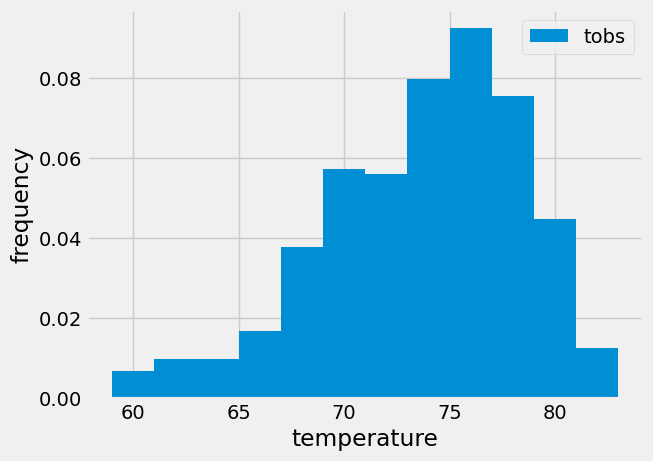

In [129]:
# create the histogram -- 
plt.hist(TOBS_list, 12, density=True, label="tobs")
plt.xlabel('temperature')
plt.ylabel('frequency')
plt.legend()
plt.show()

# Close Session

In [148]:
# Close Session
session.close()